# Preparation

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.linalg import block_diag
from tqdm import tqdm

from tensorflow.keras.optimizers import SGD, Adam # type: ignore
from tensorflow.keras.layers import Dense # type: ignore

from tf_agents.specs import tensor_spec, BoundedArraySpec

from dice_rl.networks.value_network import ValueNetwork

from utils.bedtime import computer_sleep

In [2]:
feature_matrix_boyan = np.array([
    [0, 0, 0, 1],
    [0, 0, 0.25, 0.75],
    [0, 0, 0.5, 0.5],
    [0, 0, 0.75, 0.25],
    [0, 0, 1, 0],
    [0, 0.25, 0.75, 0],
    [0, 0.5, 0.5, 0],
    [0, 0.75, 0.25, 0],
    [0, 1, 0, 0],
    [0.25, 0.75, 0, 0],
    [0.5, 0.5, 0, 0],
    [0.75, 0.25, 0, 0],
    [1, 0, 0, 0],
])

In [3]:
fc_layer_params_list = [ (), (32,), (32, 32,), (32, 32, 32,), ]

$$
\begin{align}
    \max_{v: S \times A \to \mathbb R}
    \min_{w: S \times A \to \mathbb R}
    &
    \mathbb E_{ (s_0, s, a, r, s^\prime) \sim p^{\mathcal D} }
        \Big [
            L(w, v) + \phi( w(s, a) )
        \Big ],
    \\
    \min_{ w: S \times A \to \mathbb R_{\geq 0} }
    \max_{v: S \times A \to \mathbb R, ~ u \in \mathbb R}
    &
    \mathbb E_{ (s_0, s, a, r, s^\prime) \sim p^{\mathcal D} }
        \Big [
            L(w, v) + N(w, u) - \frac{1}{4} v(s, a)^2 \cdot w(s, a)
        \Big ],
    \\
    \min_{ w: S \times A \to \mathbb R }
    \max_{v: S \times A \to \mathbb R, ~ u \in \mathbb R}
    &
    \mathbb E_{ (s_0, s, a, r, s^\prime) \sim p^{\mathcal D} }
        \Big [
            L(w, v) + N(w, u) - \frac{1}{2} v(s, a)^2
        \Big ],
\end{align}
$$

$$
\begin{gather*}
    L(w, v)
    \doteq
    (1 - \gamma)
        \cdot
        \mathbb E_{ a_0 \sim \pi(s_0) } [ v(s_0, a_0) ]
    +
    w(s, a)
        \cdot
        \left (
            \gamma \cdot \mathbb E_{ a^\prime \sim \pi(s^\prime) }
                [ v(s^\prime, a^\prime) ]
            - v(s, a)
        \right ),
    \\
    \phi(x) \doteq \frac{1}{p} |x|^p,
    \quad
    p > 1,
    \quad
    N(w, u)
    \doteq
    \lambda
        \cdot
        \Big (
            u \cdot ( w(s, a) - 1)
            -
            \frac{1}{2} u^2
        \Big ),
    \quad
    \lambda > 0.
\end{gather*}
$$

In [4]:
def get_distributions(N, p, kind):

    m = np.ones(N+1) / (N+1)
    i1 = np.identity(N)
    z1 = np.zeros([N, 1])
    e = np.eye(1, N+1)
    i2 = np.identity(N-1)
    z2 = np.zeros([N-1, 1])

    if kind == "episodic":   x = e
    if kind == "continuing": x = m

    d_0 = np.concatenate([p * m, (1-p) * m])

    P_0 = np.block([[x], [i1, z1]])
    P_1 = np.block([[x], [e], [i2, z2, z2]])

    P = np.block([
        [p * P_0, (1-p) * P_0],
        [p * P_1, (1-p) * P_1],
    ])

    d_D = np.ones(2 * (N+1)) / ( 2 * (N+1))

    return d_0, d_D, P

In [5]:
def solve_modified_backwards_bellman_equations(d_0, d_D, P, gamma=1.0):

    D = np.diag(d_D)
    I = np.identity( len(d_0) )

    if gamma < 1:
        a = ( I - gamma * P.T ) @ D
        b = (1 - gamma) * d_0

        sdc = np.linalg.solve(a, b)

    else:
        eigenvalues, eigenvectors = np.linalg.eig( (P / d_D).T )

        tol = 1e-9
        indices = np.where(np.abs(eigenvalues - 1.0) < tol)[0]

        assert len(indices) == 1
        index = int(indices[0])

        sdc = eigenvectors[:, index]

        assert np.all(sdc == np.real(sdc))
        sdc = np.real(sdc)

        sdc /= np.dot(d_D, sdc)

    return sdc

In [6]:
def get_weights_and_biases(N, M):
    a = np.eye  ( N+1, N+1 )
    b = np.zeros([N+1, M+1])
    c = np.zeros([M+1, N+1])
    d = np.eye  ( M+1, M+1 ); d[1:, :-1] -= np.identity(M)

    I = np.identity(N+1)
    def A(i):
        a = -np.ones([N+1, M+1])
        a[:, i] += 1
        return a

    W_0 = np.block([
        [np.eye  ( N+1, N+1 ), np.zeros([N+1, 1]), np.zeros([N+1, 1])],
        [np.zeros([M+1, N+1]), np.zeros([M+1, 1]), np.ones ([M+1, 1])],
    ])
    b_0 = np.block([ np.zeros(N+1), -np.arange(M+1), ])

    W_1 = np.block([
        [np.eye  ( N+1, N+1 ),  np.zeros([N+1, M+1])],
        [np.zeros([M+1, N+1]), -np.eye  ( M+1, M+1 )],
    ])
    b_1 = np.block([ np.zeros(N+1), np.ones(M+1), ])

    W_2 = np.block([ [a, b], [c, d] ])
    b_2 = np.zeros(N+1+M+1)

    W_3 = np.block([ [I, A(i)] for i in range(M+1) ])
    b_3 = np.zeros( (N+1) * (M+1) )

    W = [W_0, W_1, W_2, W_3]
    b = [b_0, b_1, b_2, b_3]

    return W, b

In [7]:
def get_network(N, M, obs_input_shape=None, parameters=None):

    if obs_input_shape is None: obs_input_shape = N + 1

    obs_spec = tensor_spec.from_spec(
        BoundedArraySpec(
            shape=(obs_input_shape,),
            dtype=np.float32,
            minimum=np.array(0, dtype=np.float32),
            maximum=np.array(1, dtype=np.float32),
            name="observation"))

    act_spec = tensor_spec.from_spec(
        BoundedArraySpec(
            shape=(),
            dtype=np.int64,
            minimum=np.array(0, dtype=np.int64),
            maximum=np.array(M, dtype=np.int64),
            name="action"))

    network = ValueNetwork(
        (obs_spec, act_spec),
        activation_fn=tf.nn.relu,
        output_activation_fn=tf.identity,
        fc_layer_params=( N+1+M+1, N+1+M+1, N+1+M+1, (N+1)*(M+1), ),
    )

    network.create_variables()

    W, b = get_weights_and_biases(N, M)

    network.variables[0].assign(W[0].T)
    network.variables[1].assign(b[0])

    network.variables[2].assign(W[1].T)
    network.variables[3].assign(b[1])

    network.variables[4].assign(W[2].T)
    network.variables[5].assign(b[2])

    network.variables[6].assign(W[3].T)
    network.variables[7].assign(b[3])

    if parameters is not None:
        W_4 = np.expand_dims(parameters, axis=1)
        b_4 = np.zeros(1)

        network.variables[8].assign(W_4)
        network.variables[9].assign(b_4)

    return network

network = get_network(N=12, M=1)

In [8]:
def manual_forward_pass(N, M, obs=None, act=None):

    W, b = get_weights_and_biases(N, M)

    if obs is None: obs = np.ones(N+1); obs[0] = 0
    if act is None: act = 0

    obs = tf.expand_dims(
        tf.convert_to_tensor(obs, dtype=tf.float32),
        axis=0)
    act = tf.expand_dims(
        tf.convert_to_tensor(act, dtype=tf.int64),
        axis=0)

    print()
    print("obs"); print(obs)
    print("act"); print(act)
    print()

    print("x_0 = (obs, act)")
    x_0 = tf.concat([
        tf.squeeze(obs),
        np.array([-1]),
        tf.cast(act, dtype=tf.float32)], axis=0)
    print(x_0); print()

    print("x_1 = relu(x_0 * W_0.T)")
    x_1 = tf.cast(np.dot(x_0, W[0].T) + b[0], dtype=tf.float32) # type: ignore
    print(x_1)
    x_1 = tf.nn.relu(x_1)
    print(x_1); print()

    print("x_2 = relu(x_1 * W_1.T)")
    x_2 = tf.cast(np.dot(x_1, W[1].T) + b[1], dtype=tf.float32)
    print(x_2)
    x_2 = tf.nn.relu(x_2)
    print(x_2); print()

    print("x_3 = relu(x_2 * W_2.T)")
    x_3 = tf.cast(np.dot(x_2, W[2].T) + b[2], dtype=tf.float32)
    print(x_3)
    x_3 = tf.nn.relu(x_3)
    print(x_3); print()

    print("x_4 = relu(x_3 * W_3.T)")
    x_4 = tf.cast(np.dot(x_3, W[3].T) + b[3], dtype=tf.float32)
    print(x_4)
    x_4 = tf.nn.relu(x_4)
    print(x_4); print()


manual_forward_pass(N=12, M=1)


obs
tf.Tensor([[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]], shape=(1, 13), dtype=float32)
act
tf.Tensor([0], shape=(1,), dtype=int64)

x_0 = (obs, act)
tf.Tensor([ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  0.], shape=(15,), dtype=float32)

x_1 = relu(x_0 * W_0.T)
tf.Tensor([ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0. -1.], shape=(15,), dtype=float32)
tf.Tensor([0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.], shape=(15,), dtype=float32)

x_2 = relu(x_1 * W_1.T)
tf.Tensor([0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(15,), dtype=float32)

x_3 = relu(x_2 * W_2.T)
tf.Tensor([0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.], shape=(15,), dtype=float32)

x_4 = relu(x_3 * W_3.T)
tf.Tensor(
[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]

In [9]:
def get_linear_to_neural_error(N, theta, analytical_solution):

    w = get_network(N=12, M=1, parameters=theta)

    x = np.identity(N+1)
    y = np.zeros(N+1)
    z = np.ones (N+1)

    obs = np.concatenate( [x, x] ) # type: ignore
    act = np.concatenate( [y, z] )

    obs = tf.convert_to_tensor(obs, dtype=np.float32)
    act = tf.convert_to_tensor(act, dtype=np.int64)

    approximate_solution, _ = w( (obs, act) )

    x = approximate_solution
    y = analytical_solution
    return np.mean( (x - y) ** 2 )

In [10]:
class BoyanChainAgent:
    def __init__(
            self,
            N, p,
            gamma, exponent, lam,
            num_steps, batch_size, learning_rate,
            max_approximate_solutions,
            feature_matrix_kind, algorithm,
        ):

        self.N = N
        self.p = p

        self.gamma = gamma
        self.exponent = exponent
        self.lam = lam

        self.analytical_solution = self.get_analytical_solution()
        self.errors = []
        self.objectives = []

        self.num_steps = num_steps
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        self.max_approximate_solutions = max_approximate_solutions
        self.approximate_solutions = []

        self.algorithm = algorithm
        self.feature_matrix_kind = feature_matrix_kind

        self.state_space = np.arange(self.N+1)
        self.action_space = np.arange(2)

        def get_rew(obs):
            if obs == 0: return 0
            if obs == 1: return -2
            if obs >= 2: return -3

        def get_obs_next(obs, act):
            A = self.gamma < 1
            x = np.random.choice(self.state_space)
            if obs == 0: return 0 if A else x
            if obs == 1: return 0
            if obs >= 2: return obs-act-1

        self.get_rew = np.vectorize(get_rew)
        self.get_obs_next = np.vectorize(get_obs_next)

    @property
    def feature_matrix_S(self):
        if self.feature_matrix_kind == "one-hot": return np.identity(self.N+1)
        if self.feature_matrix_kind == "boyan":   return feature_matrix_boyan

    @property
    def feature_matrix_SA(self):
        X = block_diag(
            self.feature_matrix_S, self.feature_matrix_S)
        return np.array(X, dtype=np.float32)

    @property
    def kind(self):
        return "episodic" if self.gamma < 1 else "continuing"

    def get_analytical_solution(self):
        d_0, d_D, P = get_distributions(self.N, self.p, self.kind)
        sdc = solve_modified_backwards_bellman_equations(d_0, d_D, P, self.gamma)

        return sdc

    def get_sample(self, batch_size):
        obs_init = np.random.choice(self.state_space, batch_size)
        act_init = np.where( np.random.random(batch_size) < self.p, 0, 1 )

        obs = np.random.choice(self.state_space,  batch_size)
        act = np.random.choice(self.action_space, batch_size)

        rew = self.get_rew(obs)

        obs_next = self.get_obs_next(obs, act)
        act_next = np.where( np.random.random(batch_size) < self.p, 0, 1 )

        sample = {
            "obs_init": obs_init,
            "act_init": act_init,
            #
            "obs": obs,
            "act": act,
            "rew": rew,
            #
            "obs_next": obs_next,
            "act_next": act_next,
        }

        return sample

    def phi(self, x):
        p = self.exponent
        return 1 / p * abs(x) ** p

    def objective(self, v_init, v, v_next, w, u):
        g = self.gamma
        l = self.lam

        L = (1 - g) * v_init + w * (g * v_next - v)
        N = l * ( u * (w-1) - 1/2 * u**2 )

        x = self.algorithm
        A = x == "DualDice"; B = x == "GenDice"; C = x == "GradientDice"
        if A: return L + self.phi(w) + 0 * u
        if B: return L + N - 1/4 * v**2 * w
        if C: return L + N - 1/2 * v**2

    @property
    def approximate_solution(self):
        pass

    def eval_step(self, learning_rate):
        grads = None; obj = None
        return grads, obj

    def get_error(self):
        x = self.approximate_solution
        y = self.analytical_solution
        return np.mean( (x - y) ** 2 )

    def eval_loop(self, verbosity=1):
        pbar = range(self.num_steps)
        if verbosity >= 1: pbar = tqdm(pbar)

        for i_step in pbar:
            learning_rate = self.learning_rate(i_step) \
                if callable(self.learning_rate) else self.learning_rate
            grads, obj = self.eval_step(learning_rate)

            if i_step % 100 == 0 or i_step == self.num_steps-1:

                err = self.get_error()
                obj = np.mean(obj) # type: ignore

                self.errors    .append([i_step, err])
                self.objectives.append([i_step, obj])

                x = self.approximate_solution
                X = self.approximate_solutions
                max_X = self.max_approximate_solutions
                if len(X) >= max_X: X.pop(0)
                X.append(x)

                if verbosity >= 1:
                    d = { "error": err, "objective": obj, }
                    pbar.set_postfix(d) # type: ignore

    @property
    def hparam_str(self):
        x = self.learning_rate( sp.Symbol("t") )
        y = self.learning_rate
        A = callable(self.learning_rate)

        return "_".join([
            f"N={self.N}", f"p={self.p}",
            f"gamma={self.gamma}", f"exponent={self.exponent}", f"lam={self.lam}",
            f"num_steps={self.num_steps}", f"batch_size={self.batch_size}", f"learning_rate={x if A else y}",
            f"feature_matrix_kind={self.feature_matrix_kind}", f"algorithm={self.algorithm}",
        ])

In [11]:
class BoyanChainAgent_Linear(BoyanChainAgent):
    def __init__(
            self,
            N, p,
            gamma, exponent, lam,
            num_steps, batch_size, learning_rate,
            max_approximate_solutions,
            feature_matrix_kind, algorithm,
            auto_diff, normalize_gradients):

        super().__init__(
            N, p,
            gamma, exponent, lam,
            num_steps, batch_size, learning_rate,
            max_approximate_solutions,
            feature_matrix_kind, algorithm,
        )

        self.auto_diff = auto_diff
        self.normalize_gradients = normalize_gradients

        K = self.feature_matrix_SA.shape[-1] # type: ignore
        self.vartheta = tf.Variable( np.ones(K), dtype=tf.float32 )
        self.theta    = tf.Variable( np.ones(K), dtype=tf.float32 )
        self.u = tf.Variable(1.0, dtype=tf.float32)

    @property
    def hparam_str(self):
        return "_".join([
            super().hparam_str,
            f"auto_diff={self.auto_diff}", f"normalize_gradients={self.normalize_gradients}"
        ])

    def get_features(self, obs, act=None):
        if act is not None:
            index = obs + act * (self.N+1)
            x = self.feature_matrix_SA[index]
        else:
            x_0 = self.get_features(obs, 0)
            x_1 = self.get_features(obs, 1)
            p = self.p
            x = p * x_0 + (1 - p) * x_1

        return x

    def get_gradients(self, sample, auto_diff, normalize_gradients, batch_size):
        if auto_diff:
            with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
                tape.watch(self.vartheta)
                tape.watch(self.theta)
                tape.watch(self.u)

                x = self.get_features(sample["obs"], sample["act"])

                x_init = self.get_features(sample["obs_init"])
                x_next = self.get_features(sample["obs_next"])

                v = tf.linalg.matvec(x, self.vartheta)
                w = tf.linalg.matvec(x, self.theta)
                u = self.u

                v_init = tf.linalg.matvec(x_init, self.vartheta)
                v_next = tf.linalg.matvec(x_next, self.vartheta)

                obj = self.objective(v_init, v, v_next, w, u)

            # grads_vartheta = tape.jacobian(obj, self.vartheta)
            # grads_theta    = tape.jacobian(obj, self.theta)
            # grads_u        = tape.jacobian(obj, self.u)

            # grad_vartheta = np.mean(grads_vartheta, axis=0) # type: ignore
            # grad_theta    = np.mean(grads_theta,    axis=0) # type: ignore
            # grad_u        = np.mean(grads_u) # type: ignore

            grad_vartheta = tape.gradient(obj, self.vartheta)
            grad_theta    = tape.gradient(obj, self.theta)
            grad_u        = tape.gradient(obj, self.u)

            grad_vartheta /= batch_size
            grad_theta    /= batch_size
            grad_u        /= batch_size

        else:
            x = self.get_features(sample["obs"], sample["act"])

            x_init = self.get_features(sample["obs_init"])
            x_next = self.get_features(sample["obs_next"])

            v = tf.linalg.matvec(x, self.vartheta)
            w = tf.linalg.matvec(x, self.theta)
            u = self.u

            v_init = tf.linalg.matvec(x_init, self.vartheta)
            v_next = tf.linalg.matvec(x_next, self.vartheta)

            obj = self.objective(v_init, v, v_next, w, u)

            v_init = tf.expand_dims(v_init, axis=1)
            v_next = tf.expand_dims(v_next, axis=1)
            w = tf.expand_dims(w, axis=1)
            v = tf.expand_dims(v, axis=1)

            if self.algorithm == "GradientDice":
                grad_vartheta = (1 - self.gamma) * x_init + w * self.gamma * x_next - w * x - v * x
                grad_theta    = self.gamma * v_next * x - v * x + self.lam * self.u * x
                grad_u        = self.lam * ( w - 1 - self.u )

            else:
                raise NotImplementedError

            grad_vartheta = tf.reduce_mean(grad_vartheta, axis=0)
            grad_theta    = tf.reduce_mean(grad_theta,    axis=0)
            grad_u        = tf.reduce_mean(grad_u)

        if normalize_gradients:
            grad_kappa = np.concatenate([
                grad_vartheta, grad_theta, tf.expand_dims(grad_u, axis=0) ])
            norm = tf.linalg.norm(grad_kappa)

            grad_vartheta /= norm
            grad_theta    /= norm
            grad_u        /= norm

        grads = { "theta": grad_theta, "vartheta": grad_vartheta, "u": grad_u, }

        return grads, obj

    def eval_step(self, learning_rate, sample=None):
        if sample is None: sample = self.get_sample(self.batch_size)

        grads, obj = self.get_gradients(
            sample, self.auto_diff, self.normalize_gradients, self.batch_size)

        self.vartheta = self.vartheta + learning_rate * grads["vartheta"]
        self.theta    = self.theta    - learning_rate * grads["theta"]
        self.u        = self.u        + learning_rate * grads["u"]

        return grads, obj

    @property
    def approximate_solution(self):
        return tf.linalg.matvec(self.feature_matrix_SA, self.theta)

In [12]:
class BoyanChainAgent_Neural(BoyanChainAgent):
    def __init__(
            self,
            N, p,
            gamma, exponent, lam,
            num_steps, batch_size, learning_rate,
            max_approximate_solutions,
            feature_matrix_kind, algorithm,
            optimizer, fc_layer_params=None, orth_reg_coeff=0.0, bias=False):

        super().__init__(
            N, p,
            gamma, exponent, lam,
            num_steps, batch_size, learning_rate,
            max_approximate_solutions,
            feature_matrix_kind, algorithm,
        )

        if fc_layer_params is None:
            N, M = self.N, 2
            fc_layer_params = ( N+1+M+1, N+1+M+1, N+1+M+1, (N+1)*(M+1), )

        self.fc_layer_params = fc_layer_params
        self.orth_reg_coeff = orth_reg_coeff
        self.bias = bias

        lr = learning_rate(0) if callable(learning_rate) else learning_rate
        if optimizer == "SGD":  get_optimizer = SGD
        if optimizer == "Adam": get_optimizer = Adam

        self.optimizer_v = get_optimizer(lr)
        self.optimizer_w = get_optimizer(lr)
        self.optimizer_u = get_optimizer(lr)

        v, w, u = self.get_networks()
        self.v = v
        self.w = w
        self.u = u

    @property
    def hparam_str(self):
        return "_".join([
            super().hparam_str,
            f"fc_layer_params={self.fc_layer_params}",
            f"orth_reg_coeff={self.orth_reg_coeff}",
        ])

    def get_spec(self):
        obs_spec = tensor_spec.from_spec(
            BoundedArraySpec(
                shape=(self.feature_matrix_S.shape[-1],),
                dtype=np.float32,
                minimum=np.array(0, dtype=np.float32),
                maximum=np.array(1, dtype=np.float32),
                name="observation"))

        act_spec = tensor_spec.from_spec(
            BoundedArraySpec(
                shape=(),
                dtype=np.int64,
                minimum=np.array(0, dtype=np.int64),
                maximum=np.array(1, dtype=np.int64),
                name="action"))
        
        return obs_spec, act_spec

    def get_networks(self):
        x = tf.square
        y = tf.identity
        A = self.algorithm == "GenDice"

        v = ValueNetwork(
            self.get_spec(),
            fc_layer_params=self.fc_layer_params,
        )
        w = ValueNetwork(
            self.get_spec(),
            fc_layer_params=self.fc_layer_params,
            output_activation_fn=x if A else y,
        )
        u = tf.Variable(1.0)

        v.create_variables()
        w.create_variables()

        if not self.bias:
            b = np.zeros(1)

            v.variables[-1].assign(b)
            w.variables[-1].assign(b)

            v.variables[-1].trainable = False
            w.variables[-1].trainable = False

        return v, w, u

    def set_networks_from_linear(self, theta, vartheta):
        N, M = self.N, 2
        self.fc_layer_params = ( N+1+M+1, N+1+M+1, N+1+M+1, (N+1)*(M+1), )

        self.v = get_network(
            self.N, 1, self.feature_matrix_S.shape[-1],
            parameters=vartheta)
        self.w = get_network(
            self.N, 1, self.feature_matrix_S.shape[-1],
            parameters=theta)
        self.u = tf.Variable(0.0)

    def get_obs_act(self, obs, act):
        obs = self.feature_matrix_S[obs] # type: ignore

        obs = tf.convert_to_tensor(obs, dtype=tf.float32)
        act = tf.convert_to_tensor(act, dtype=tf.int64)

        return obs, act

    def get_value(self, network, obs, act=None):
        if act is not None:
            obs_act = self.get_obs_act(obs, act)
            value, _ = network(obs_act)

        else:
            act_0 = np.zeros(obs.shape[0], dtype=np.int64)
            act_1 = np.ones (obs.shape[0], dtype=np.int64)
            value_0 = self.get_value(network, obs, act_0)
            value_1 = self.get_value(network, obs, act_1)
            p = self.p
            value = p * value_0 + (1 - p) * value_1

        return value

    def orthogonal_regularization(self, network):
        regularizer = 0
        for layer in network.layers:
            if isinstance(layer, Dense):
                prod = tf.matmul(
                    tf.transpose(layer.kernel), layer.kernel )
                regularizer += tf.reduce_sum(
                    tf.math.square(prod * (1 - tf.eye(prod.shape[0]))) )
        return float(regularizer)

    def objective(self, v_init, v, v_next, w, u):
        obj = super().objective(v_init, v, v_next, w, u)

        reg_v = self.orthogonal_regularization(self.v)
        reg_w = self.orthogonal_regularization(self.w)

        obj += self.orth_reg_coeff * ( reg_v + reg_w ) # type: ignore

        return obj

    def get_gradients(self, sample, batch_size):
        with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
            tape.watch([var.value for var in self.v.variables])
            tape.watch([var.value for var in self.w.variables])
            tape.watch([self.u])

            v = self.get_value(self.v, sample["obs"], sample["act"])
            w = self.get_value(self.w, sample["obs"], sample["act"])
            u = self.u

            v_init = self.get_value(self.v, sample["obs_init"])
            v_next = self.get_value(self.v, sample["obs_next"])

            obj = self.objective(v_init, v, v_next, w, u)
            obj_inv = -obj # type: ignore

        grad_v = tape.gradient(obj_inv, self.v.variables)
        grad_w = tape.gradient(obj,     self.w.variables)
        grad_u = tape.gradient(obj_inv, [self.u])

        grad_v = [grad / batch_size for grad in grad_v] # type: ignore
        grad_w = [grad / batch_size for grad in grad_w] # type: ignore
        grad_u = [grad / batch_size for grad in grad_u] # type: ignore

        if not self.bias:
            grad_v[-1] *= 0
            grad_w[-1] *= 0

        grads = { "v": grad_v, "w": grad_w, "u": grad_u, }

        return grads, obj

    def eval_step(self, learning_rate, sample=None):
        if sample is None: sample = self.get_sample(self.batch_size)
        grads, obj = self.get_gradients(sample, self.batch_size)

        if callable(self.learning_rate):
            self.optimizer_v.learing_rate = learning_rate
            self.optimizer_w.learing_rate = learning_rate
            self.optimizer_u.learing_rate = learning_rate

        self.optimizer_v.apply_gradients( zip(grads["v"], self.v.variables) ) # type: ignore
        self.optimizer_w.apply_gradients( zip(grads["w"], self.w.variables) ) # type: ignore
        self.optimizer_u.apply_gradients( zip(grads["u"], [self.u]) ) # type: ignore

        return grads, obj

    @property
    def approximate_solution(self):
        x = self.state_space
        y = np.zeros(self.N+1)
        z = np.ones (self.N+1)

        obs = np.concatenate( [x, x] ) # type: ignore
        act = np.concatenate( [y, z] )

        obs = np.array(obs, dtype=np.int64)
        act = np.array(act, dtype=np.int64)

        approximate_solution = self.get_value(self.w, obs, act)
        return approximate_solution

In [13]:
class BoyanChainAgent_Experimental(BoyanChainAgent_Neural):
    def get_spec(self):
        return tensor_spec.from_spec(
            BoundedArraySpec(
                shape=(self.feature_matrix_SA.shape[-1],),
                dtype=np.float32,
                minimum=np.array(0, dtype=np.float32),
                maximum=np.array(1, dtype=np.float32),
                name="observation"))

    def set_networks_from_linear(self, theta, vartheta):
        self.fc_layer_params = ()

        v, w, u = self.get_networks()

        W_theta    = np.expand_dims(theta,    axis=1)
        W_vartheta = np.expand_dims(vartheta, axis=1)
        b = np.zeros(1)

        v.variables[0].assign(W_vartheta)
        w.variables[0].assign(W_theta)

        v.variables[1].assign(b)
        w.variables[1].assign(b)

        v.variables[1].trainable = False
        w.variables[1].trainable = False

        self.v = v
        self.w = w
        self.u = u

    def get_obs_act(self, obs, act):
        obs, act = super().get_obs_act(obs, act)

        obs = np.array(obs)
        act = np.array(act)

        obs_act = np.zeros(
            [obs.shape[0], obs.shape[-1] * 2],dtype=np.float32) # type: ignore

        A = np.array([[0, obs.shape[-1]]], dtype=np.int64)
        reps = [obs.shape[0], 1]
        x = np.tile(A, reps)
        y = np.expand_dims(act * obs.shape[-1], axis=1)
        keys = x + y

        for i in range(obs.shape[0]):
            k1, k2 = keys[i]
            obs_act[i][k1:k2] = obs[i]

        return tf.convert_to_tensor(obs_act, dtype=tf.float32)

In [14]:
def moving_average(x, w):
    # https://stackoverflow.com/a/54628145/16192280
    return np.convolve(x, np.ones(w), 'valid') / w

In [15]:
def group_barplot(
        group_names, grouped_values, figsize=None,
        title=None, ylabel=None, ylim=None, ylog=False,
        bar_width=0.25, bar_labels=False, legend_loc=None):
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

    _, ax = plt.subplots( layout="constrained", figsize=figsize, )

    x = np.arange( len(group_names) )

    multiplier = 0
    for attribute, measurement in grouped_values.items():
        offset = bar_width * multiplier
        rects = ax.bar(x + offset, measurement, bar_width, label=attribute)
        if bar_labels: ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xticks(x + bar_width, group_names)
    ax.legend(loc=legend_loc, ncols=3)

    if title  is not None: ax.set_title(title)
    if ylabel is not None: ax.set_ylabel(ylabel)
    if ylim   is not None: ax.set_ylim(ylim)

    if ylog: ax.set_yscale("log")

    plt.show()

In [16]:
def plot_agents(N, agents, labels=None, title=None, ma_mse=None, ma_obj=None, ma_se=1):

    _, (ax_mse, ax_obj, ax_mix) = plt.subplots(
        ncols=3, figsize=(16, 4))

    for agent in agents:
        x_mse, y_mse = np.array(agent.errors    ).T
        x_obj, y_obj = np.array(agent.objectives).T

        if ma_mse is not None:
            x_mse = x_mse[ma_mse-1:]
            y_mse = moving_average(y_mse, ma_mse)

        if ma_obj is not None:
            x_obj = x_obj[ma_obj-1:]
            y_obj = moving_average(y_obj, ma_obj)

        ax_mse.plot(x_mse, y_mse)
        ax_obj.plot(x_obj, y_obj)

        ax_mix.scatter(
            [mse for _, mse in agent.errors],
            [obj for _, obj in agent.objectives],
            s=1
        )

    ax_mse.set_yscale("log")
    ax_mix.set_xscale("log")

    ax_mse.set_xlabel("steps")
    ax_mse.set_ylabel("error")

    ax_obj.set_xlabel("steps")
    ax_obj.set_ylabel("objective")

    ax_mix.set_xlabel("error")
    ax_mix.set_ylabel("objective")

    for ax in [ax_mse, ax_obj, ax_mix]:
        ax.grid(linestyle=":")

    if labels is not None: ax_mse.legend(labels)

    ax_obj.set_ylim([-0.25, 0.25])
    ax_mix.set_ylim([-0.25, 0.25])

    if title is not None: plt.suptitle(title)
    plt.show()

    if labels is None: labels = [None] * len(agents)

    def get_error(agent):
        approximate_solutions = agent.approximate_solutions
        if ma_se is not None: approximate_solutions = approximate_solutions[-ma_se:]
        approximate_solution = np.mean(approximate_solutions, axis=0)
        return ( approximate_solution - agent.analytical_solution ) ** 2

    group_barplot(
        group_names=[f"({i}, 0)" for i in range(N+1)] + [f"({i}, 1)" for i in range(N+1)],
        grouped_values={
            label: get_error(agent) for agent, label in zip(agents, labels) },
        figsize=(15, 5),
        title="error",
        bar_width=0.9 / len(agents),
        ylog=True,
    )

# Linear

In [18]:
agents_linear = {}

In [18]:
agents_linear[0.05] = []

try:
    for normalize_gradients in [True, False]:
        agent = BoyanChainAgent_Linear(
            N=12, p=0.1,
            gamma=0.9, exponent=1.5, lam=1.0,
            num_steps=200_000, batch_size=64, learning_rate=0.05,
            max_approximate_solutions=16,
            feature_matrix_kind="one-hot", algorithm="GradientDice",
            auto_diff=False, normalize_gradients=normalize_gradients,
        )
        agent.eval_loop()
        agents_linear[0.05].append(agent)

except: pass

100%|██████████| 200000/200000 [05:04<00:00, 657.61it/s, error=0.000349, objective=-0.00213] 


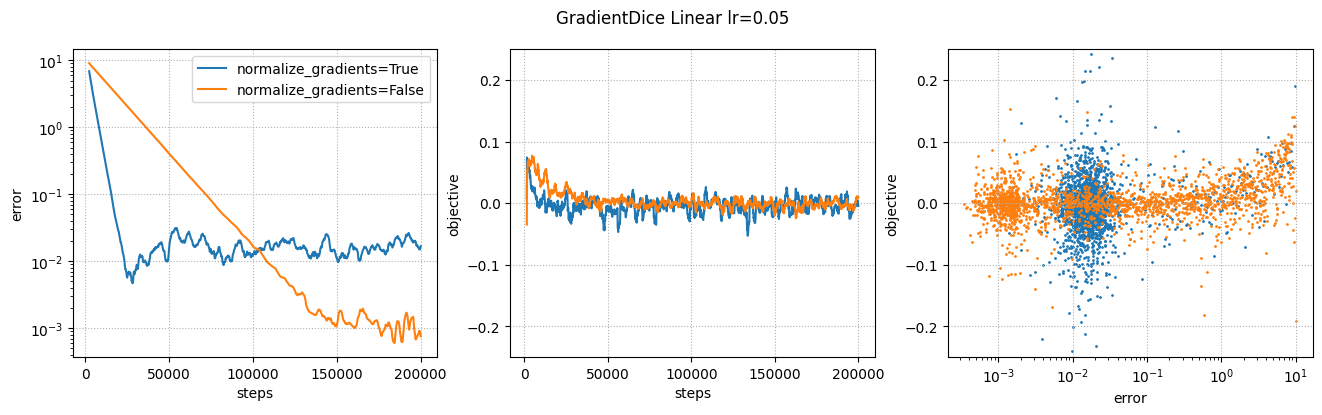

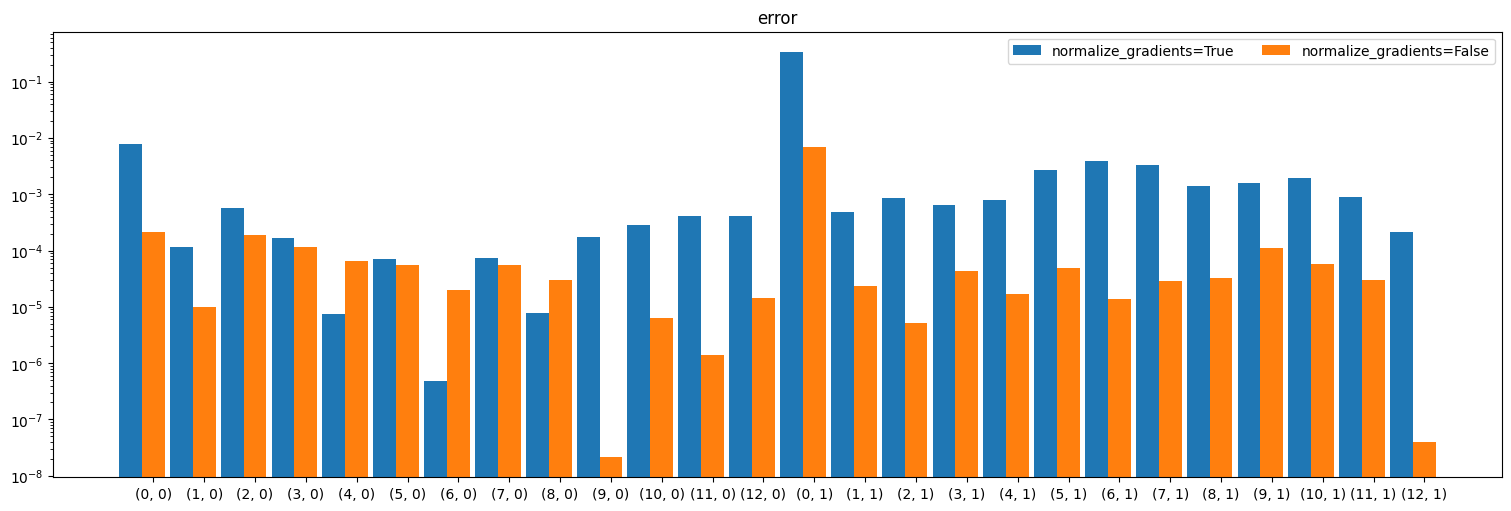

In [19]:
plot_agents(
    N=12, agents=agents_linear[0.05], labels=[f"normalize_gradients={bool}" for bool in [True, False]],
    title="GradientDice Linear lr=0.05", ma_mse=24, ma_obj=16, ma_se=None) # type: ignore

In [19]:
agents_linear[0.01] = []

try:
    for normalize_gradients in [True, False]:
        agent = BoyanChainAgent_Linear(
            N=12, p=0.1,
            gamma=0.9, exponent=1.5, lam=1.0,
            num_steps=2_000_000, batch_size=64, learning_rate=0.01,
            max_approximate_solutions=16,
            feature_matrix_kind="one-hot", algorithm="GradientDice",
            auto_diff=False, normalize_gradients=normalize_gradients,
        )
        agent.eval_loop()
        agents_linear[0.01].append(agent)

except: pass

100%|██████████| 2000000/2000000 [52:04<00:00, 640.03it/s, error=0.000142, objective=-0.0149]   


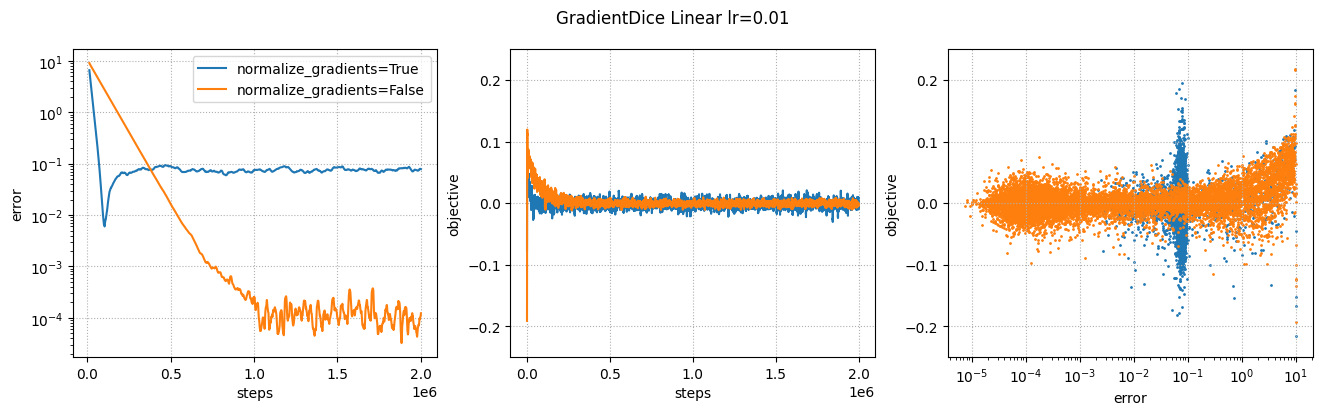

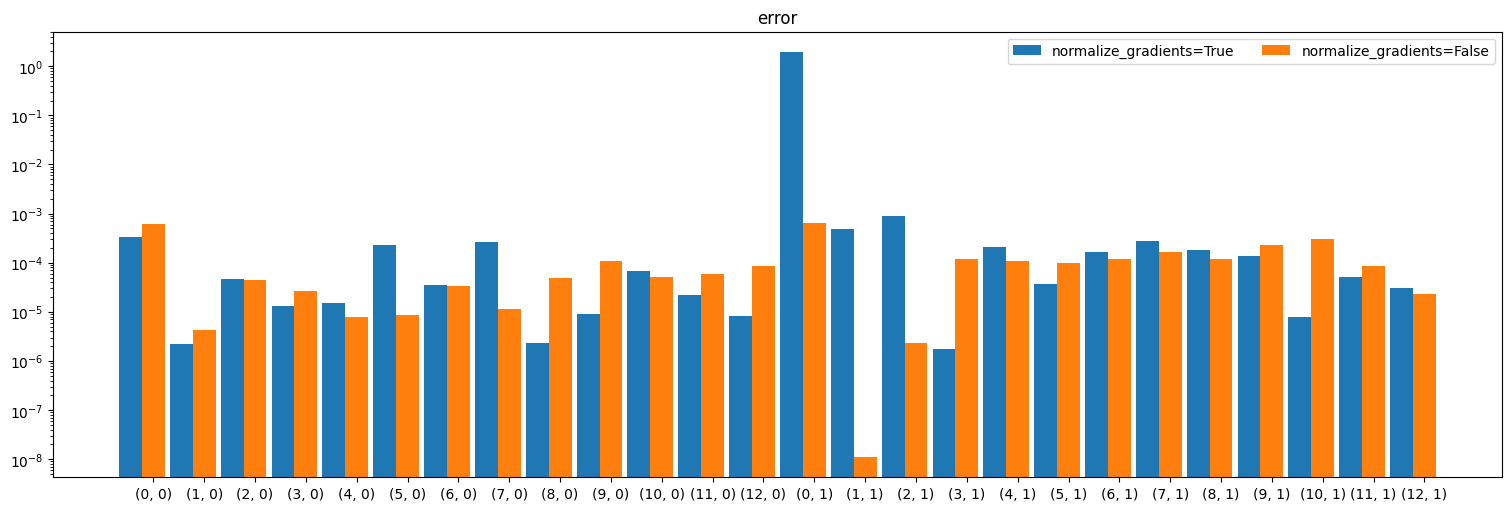

In [23]:
plot_agents(
    N=12, agents=agents_linear[0.01], labels=[f"normalize_gradients={bool}" for bool in [True, False]],
    title="GradientDice Linear lr=0.01", ma_mse=128, ma_obj=16, ma_se=None) # type: ignore

# Neural

In [17]:
agents_neural_SGD = {}

## `bias=False`

In [23]:
agents_neural_SGD[(0.05, False)] = []

try:
    for fc_layer_params in fc_layer_params_list:
        agent = BoyanChainAgent_Neural(
            N=12, p=0.1,
            gamma=0.9, exponent=1.5, lam=1.0,
            num_steps=200_000, batch_size=64, learning_rate=0.05,
            max_approximate_solutions=16,
            feature_matrix_kind="one-hot", algorithm="GradientDice",
            optimizer="SGD", fc_layer_params=fc_layer_params, bias=False,
        )
        agent.eval_loop()
        agents_neural_SGD[(0.05, False)].append(agent)

except: pass

100%|██████████| 200000/200000 [1:47:38<00:00, 30.97it/s, error=0.00394, objective=-0.00556]  


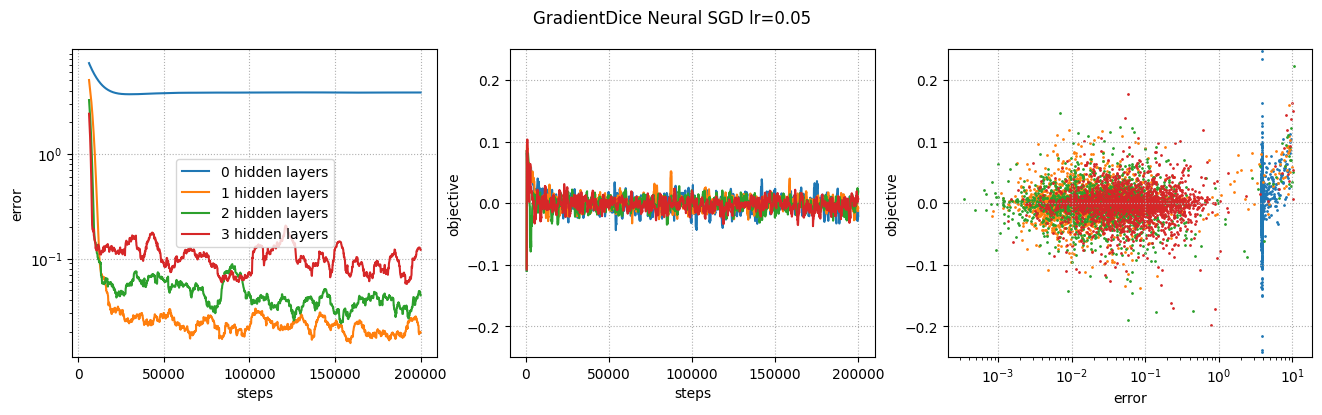

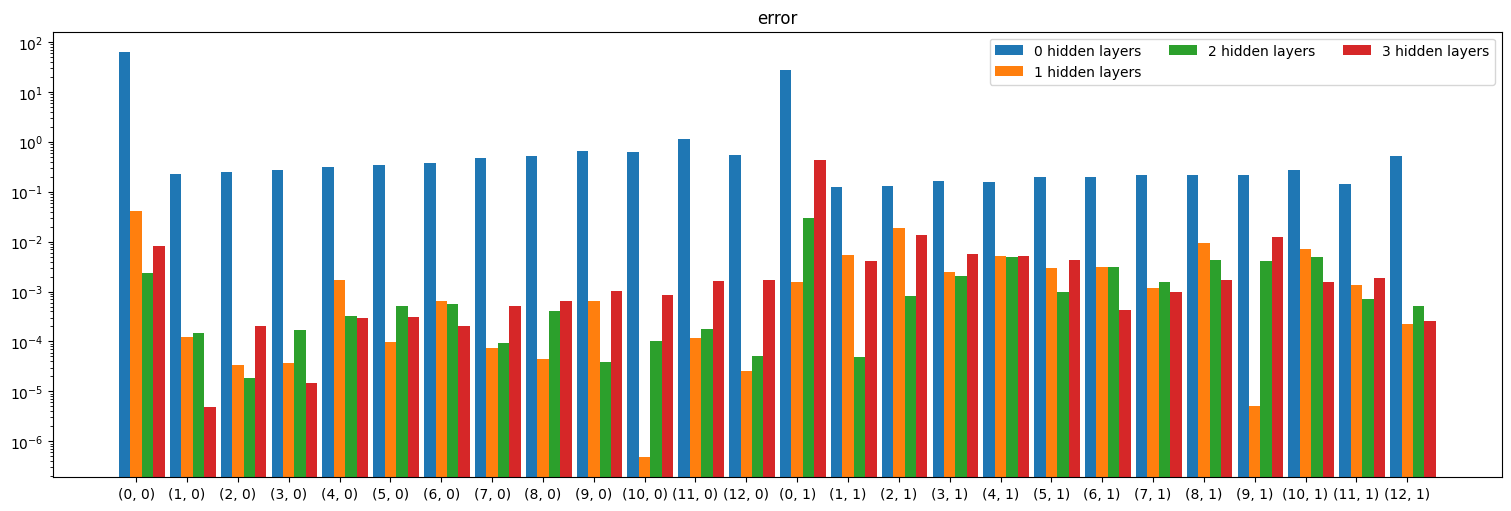

In [24]:
plot_agents(
    N=12, agents=agents_neural_SGD[(0.05, False)], labels=[f"{i} hidden layers" for i, _ in enumerate(agents_neural_SGD[(0.05, False)])],
    title="GradientDice Neural SGD lr=0.05 bias=False", ma_mse=64, ma_obj=8, ma_se=None) # type: ignore

In [25]:
agents_neural_SGD[(0.01, False)] = []

try:
    for fc_layer_params in fc_layer_params_list:
        agent = BoyanChainAgent_Neural(
            N=12, p=0.1,
            gamma=0.9, exponent=1.5, lam=1.0,
            num_steps=200_000, batch_size=64, learning_rate=0.01,
            max_approximate_solutions=16,
            feature_matrix_kind="one-hot", algorithm="GradientDice",
            optimizer="SGD", fc_layer_params=fc_layer_params, bias=False,
        )
        agent.eval_loop()
        agents_neural_SGD[(0.01, False)].append(agent)

except: pass

100%|██████████| 200000/200000 [1:48:43<00:00, 30.66it/s, error=0.0125, objective=-0.00853]    


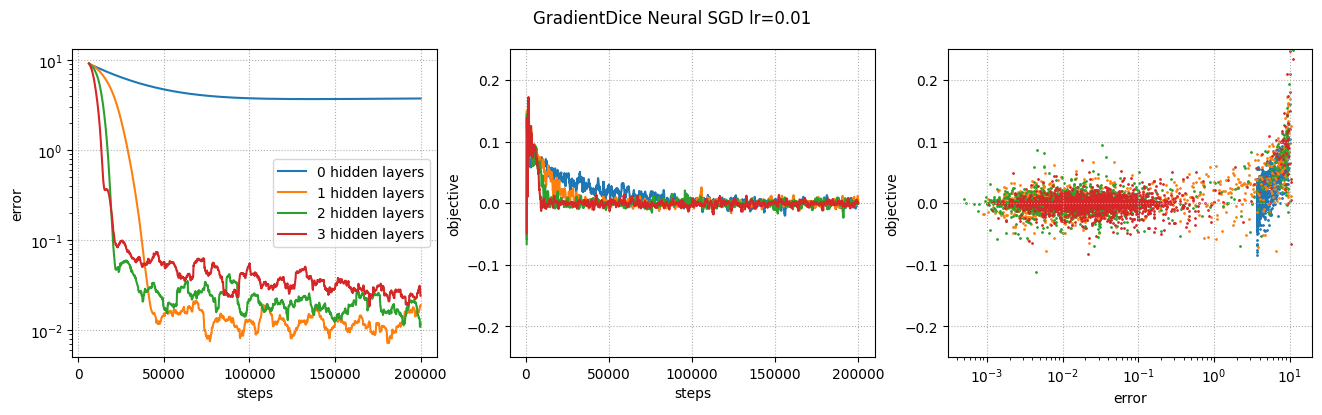

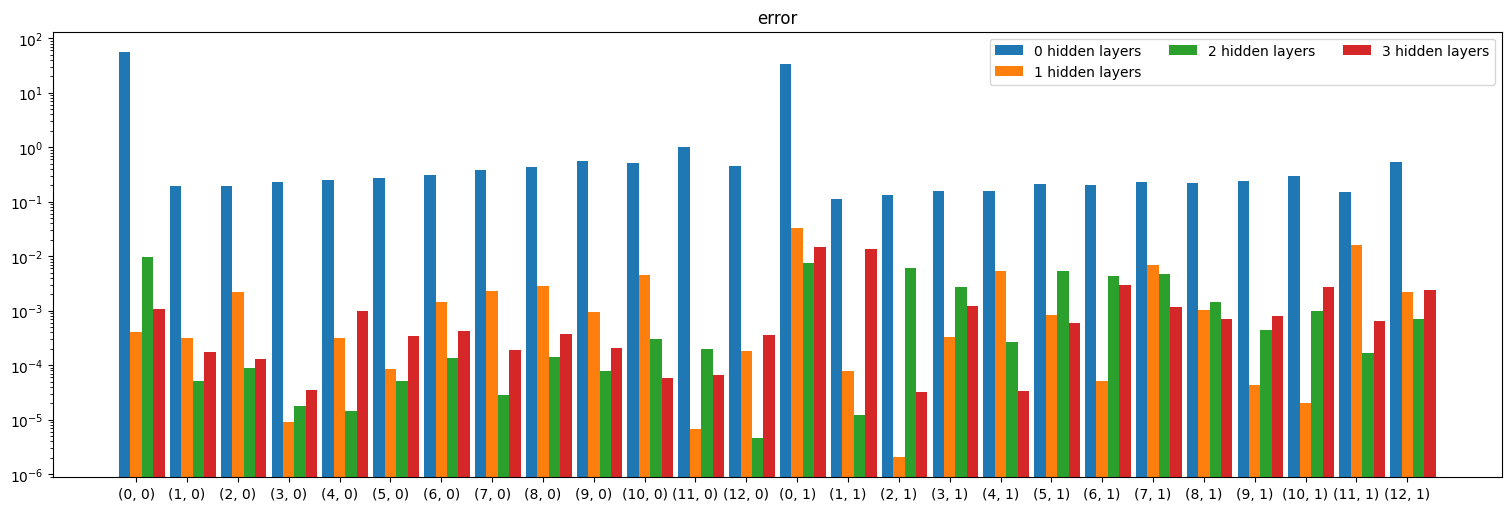

In [26]:
plot_agents(
    N=12, agents=agents_neural_SGD[(0.01, False)], labels=[f"{i} hidden layers" for i, _ in enumerate(agents_neural_SGD[(0.01, False)])],
    title="GradientDice Neural SGD lr=0.01 bias=False", ma_mse=64, ma_obj=8, ma_se=None) # type: ignore

## `bias=True`

In [25]:
agents_neural_SGD[(0.05, True)] = []

try:
    for fc_layer_params in fc_layer_params_list:
        agent = BoyanChainAgent_Neural(
            N=12, p=0.1,
            gamma=0.9, exponent=1.5, lam=1.0,
            num_steps=200_000, batch_size=64, learning_rate=0.05,
            max_approximate_solutions=16,
            feature_matrix_kind="one-hot", algorithm="GradientDice",
            optimizer="SGD", fc_layer_params=fc_layer_params, bias=True,
        )
        agent.eval_loop()
        agents_neural_SGD[(0.05, True)].append(agent)

except: pass

100%|██████████| 200000/200000 [1:48:13<00:00, 30.80it/s, error=0.312, objective=0.00172]      


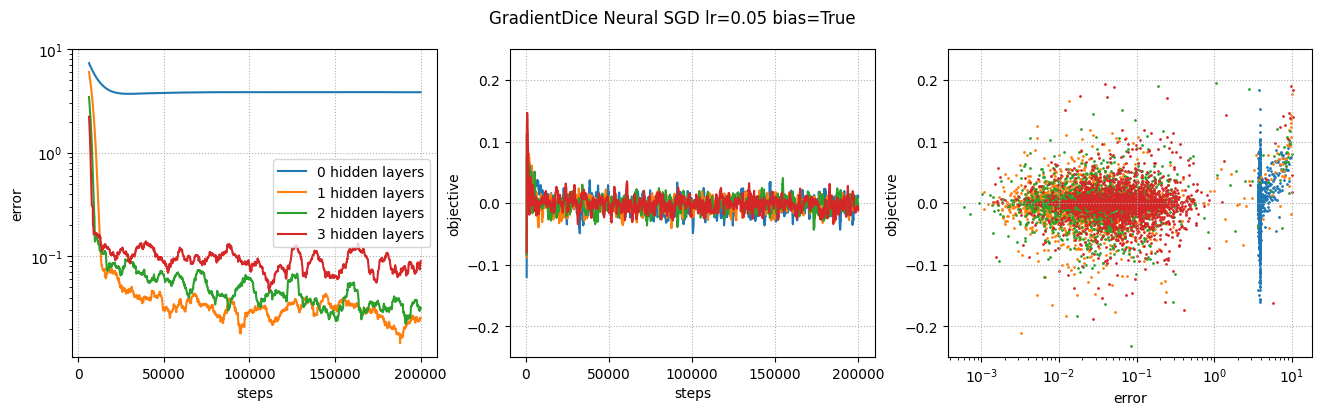

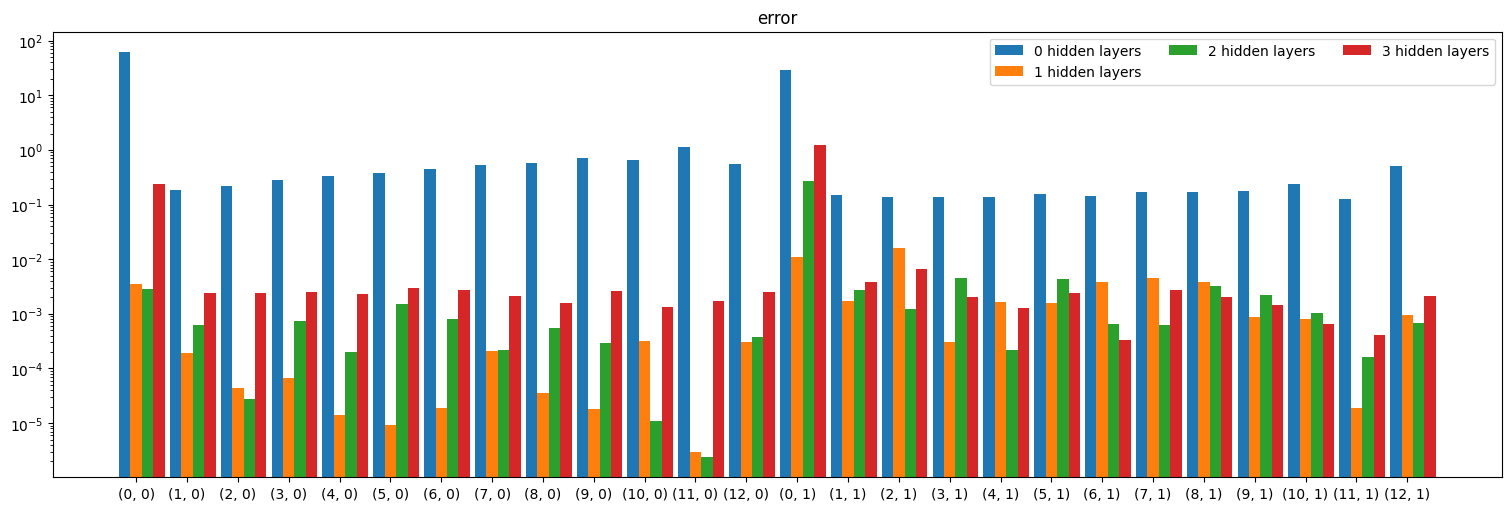

In [26]:
plot_agents(
    N=12, agents=agents_neural_SGD[(0.05, True)], labels=[f"{i} hidden layers" for i, _ in enumerate(agents_neural_SGD[(0.05, True)])],
    title="GradientDice Neural SGD lr=0.05 bias=True", ma_mse=64, ma_obj=8, ma_se=None) # type: ignore

In [27]:
agents_neural_SGD[(0.01, True)] = []

try:
    for fc_layer_params in fc_layer_params_list:
        agent = BoyanChainAgent_Neural(
            N=12, p=0.1,
            gamma=0.9, exponent=1.5, lam=1.0,
            num_steps=200_000, batch_size=64, learning_rate=0.01,
            max_approximate_solutions=16,
            feature_matrix_kind="one-hot", algorithm="GradientDice",
            optimizer="SGD", fc_layer_params=fc_layer_params, bias=True,
        )
        agent.eval_loop()
        agents_neural_SGD[(0.01, True)].append(agent)

except: pass

100%|██████████| 200000/200000 [1:48:27<00:00, 30.73it/s, error=0.0144, objective=-0.00343]   


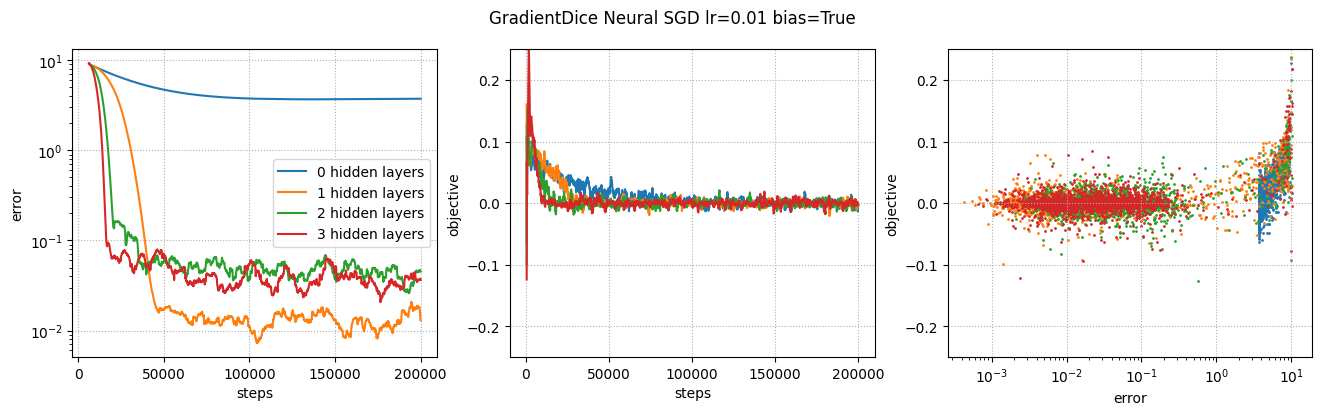

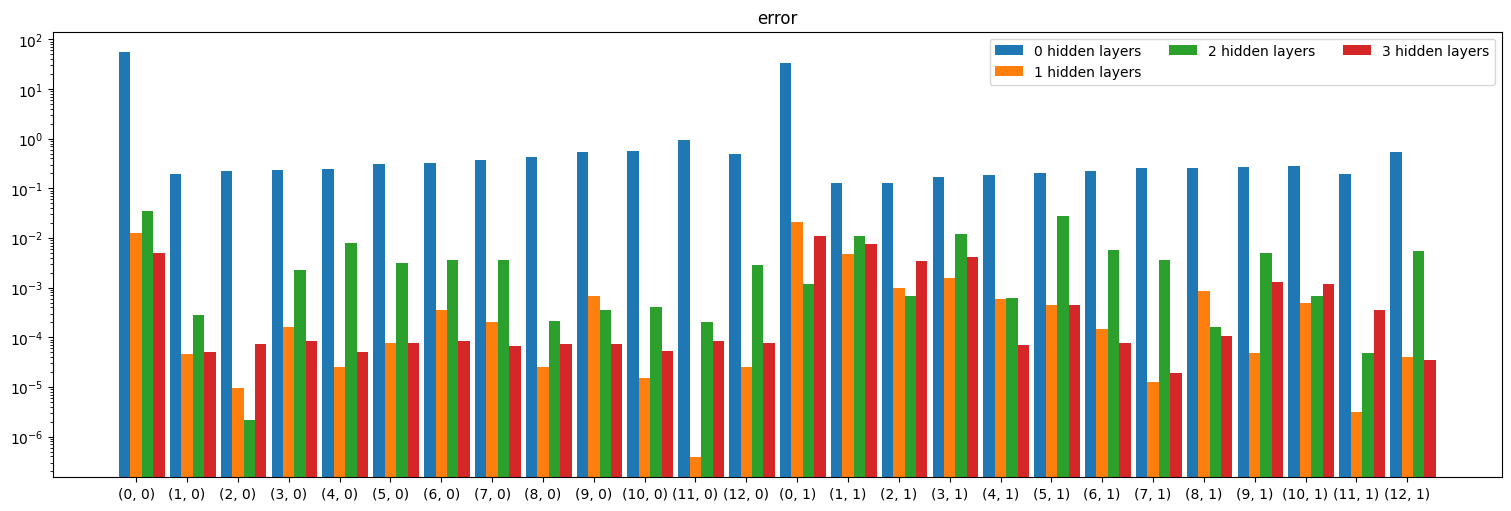

In [28]:
plot_agents(
    N=12, agents=agents_neural_SGD[(0.01, True)], labels=[f"{i} hidden layers" for i, _ in enumerate(agents_neural_SGD[(0.01, True)])],
    title="GradientDice Neural SGD lr=0.01 bias=True", ma_mse=64, ma_obj=8, ma_se=None) # type: ignore

In [18]:
agents_neural_SGD[(0.005, True)] = []

try:
    for fc_layer_params in fc_layer_params_list:
        agent = BoyanChainAgent_Neural(
            N=12, p=0.1,
            gamma=0.9, exponent=1.5, lam=1.0,
            num_steps=200_000, batch_size=64, learning_rate=0.005,
            max_approximate_solutions=16,
            feature_matrix_kind="one-hot", algorithm="GradientDice",
            optimizer="SGD", fc_layer_params=fc_layer_params, bias=True,
        )
        agent.eval_loop()
        agents_neural_SGD[(0.005, True)].append(agent)

except: pass

100%|██████████| 200000/200000 [1:55:13<00:00, 28.93it/s, error=0.0141, objective=0.000573]  


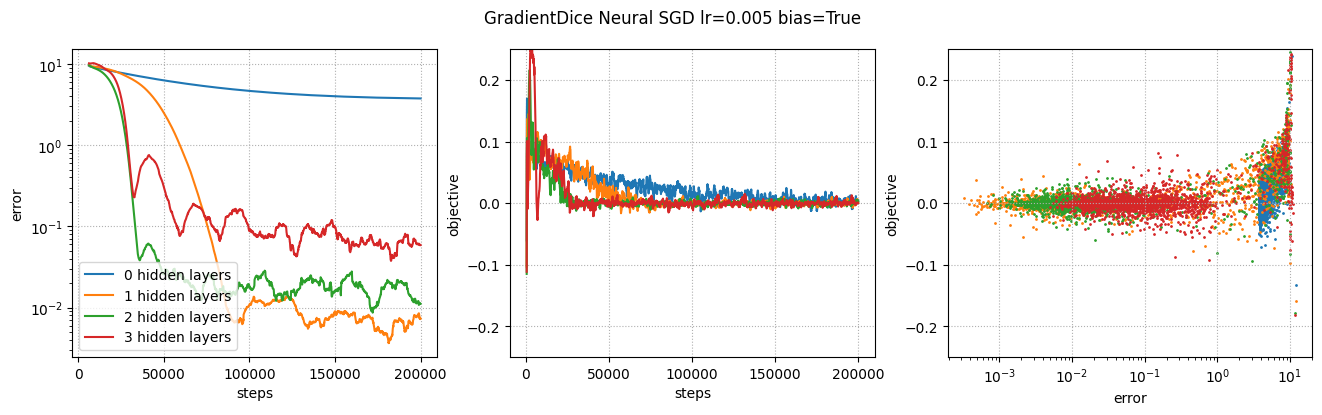

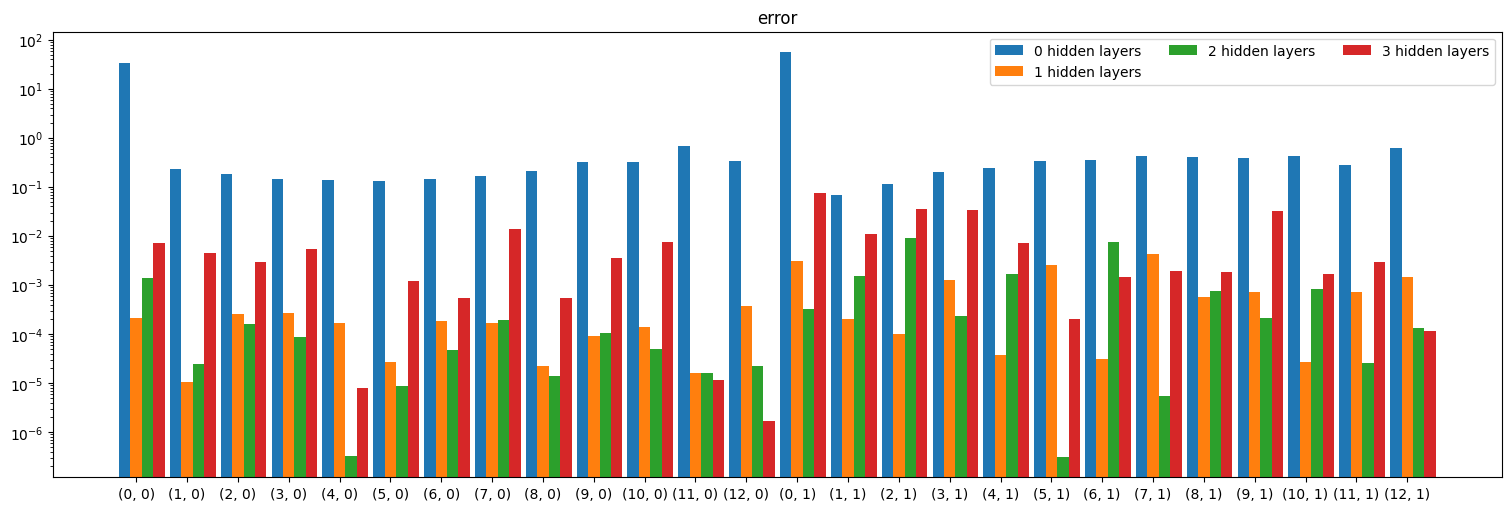

In [19]:
plot_agents(
    N=12, agents=agents_neural_SGD[(0.005, True)], labels=[f"{i} hidden layers" for i, _ in enumerate(agents_neural_SGD[(0.005, True)])],
    title="GradientDice Neural SGD lr=0.005 bias=True", ma_mse=64, ma_obj=8, ma_se=None) # type: ignore

In [20]:
agents_neural_SGD[(0.001, True)] = []

try:
    for fc_layer_params in fc_layer_params_list:
        agent = BoyanChainAgent_Neural(
            N=12, p=0.1,
            gamma=0.9, exponent=1.5, lam=1.0,
            num_steps=200_000, batch_size=64, learning_rate=0.001,
            max_approximate_solutions=16,
            feature_matrix_kind="one-hot", algorithm="GradientDice",
            optimizer="SGD", fc_layer_params=fc_layer_params, bias=True,
        )
        agent.eval_loop()
        agents_neural_SGD[(0.001, True)].append(agent)

except: pass

100%|██████████| 200000/200000 [1:57:49<00:00, 28.29it/s, error=0.0111, objective=0.00229]    


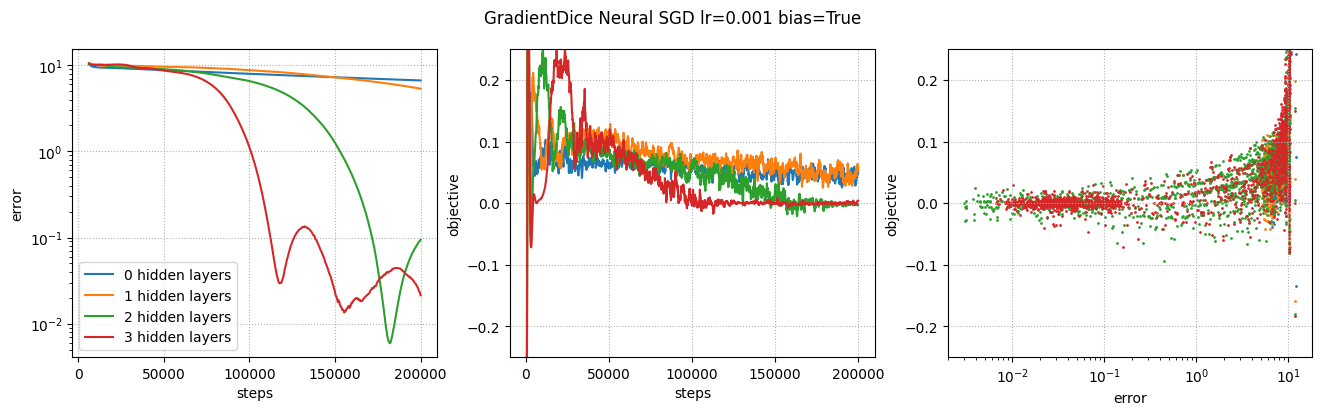

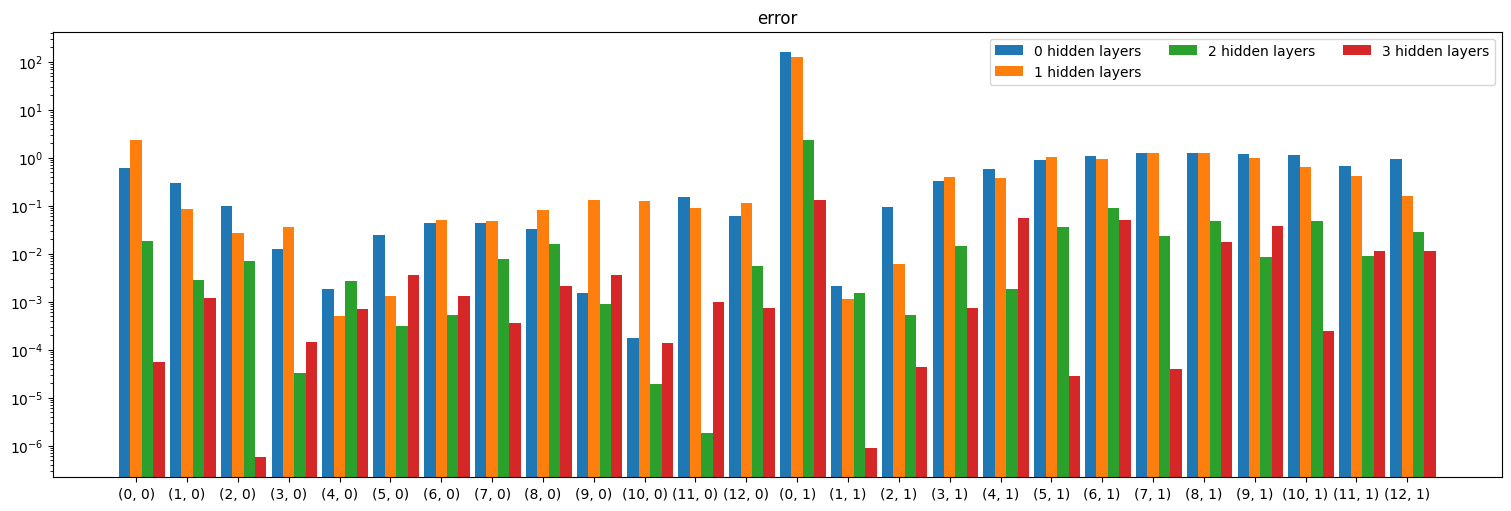

In [21]:
plot_agents(
    N=12, agents=agents_neural_SGD[(0.001, True)], labels=[f"{i} hidden layers" for i, _ in enumerate(agents_neural_SGD[(0.001, True)])],
    title="GradientDice Neural SGD lr=0.001 bias=True", ma_mse=64, ma_obj=8, ma_se=None) # type: ignore

# Experimental

In [17]:
agents_experimental_SGD = {}

## `bias=False`

In [110]:
agents_experimental_SGD[(0.05, False)] = []

try:
    for fc_layer_params in fc_layer_params_list:
        agent = BoyanChainAgent_Experimental(
            N=12, p=0.1,
            gamma=0.9, exponent=1.5, lam=1.0,
            num_steps=200_000, batch_size=64, learning_rate=0.05,
            max_approximate_solutions=16,
            feature_matrix_kind="one-hot", algorithm="GradientDice",
            optimizer="SGD", fc_layer_params=fc_layer_params, bias=False,
        )
        agent.eval_loop()
        agents_experimental_SGD[(0.05, False)].append(agent)

except: pass

100%|██████████| 200000/200000 [1:49:40<00:00, 30.39it/s, error=0.362, objective=-0.0186]     


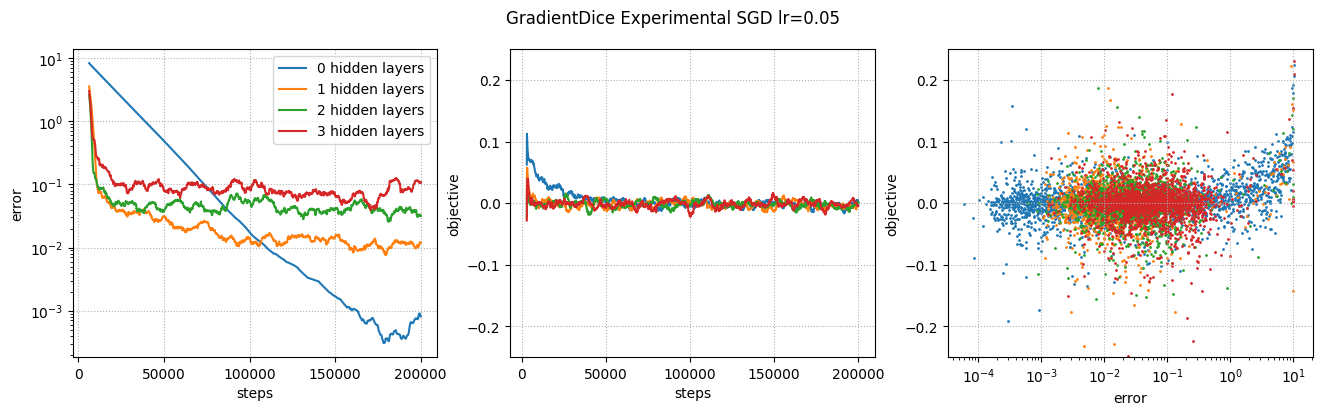

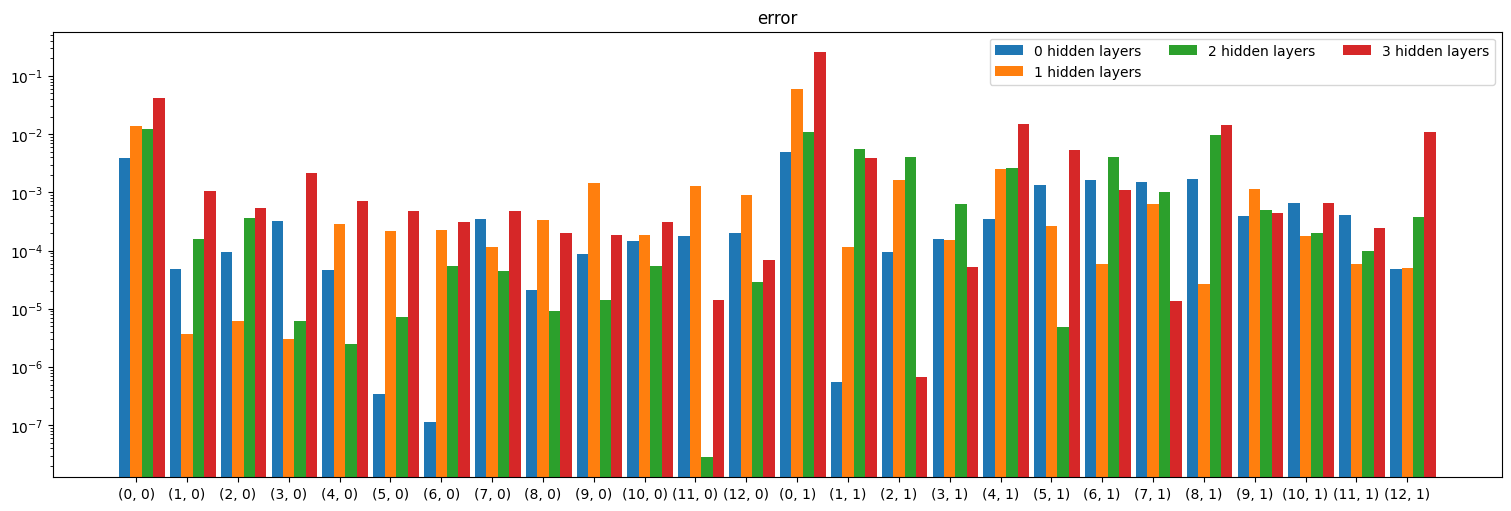

In [111]:
plot_agents(
    N=12, agents=agents_experimental_SGD[(0.05, False)], labels=[f"{i} hidden layers" for i, _ in enumerate(agents_experimental_SGD[(0.05, False)])],
    title="GradientDice Experimental SGD lr=0.05 bias=False", ma_mse=64, ma_obj=32, ma_se=None) # type: ignore

In [112]:
agents_experimental_SGD[(0.01, False)] = []

try:
    for fc_layer_params in fc_layer_params_list:
        agent = BoyanChainAgent_Experimental(
            N=12, p=0.1,
            gamma=0.9, exponent=1.5, lam=1.0,
            num_steps=200_000, batch_size=64, learning_rate=0.01,
            max_approximate_solutions=16,
            feature_matrix_kind="one-hot", algorithm="GradientDice",
            optimizer="SGD", fc_layer_params=fc_layer_params, bias=False,
        )
        agent.eval_loop()
        agents_experimental_SGD[(0.01, False)].append(agent)

except: pass

100%|██████████| 200000/200000 [1:48:54<00:00, 30.61it/s, error=0.0215, objective=-0.0159]     


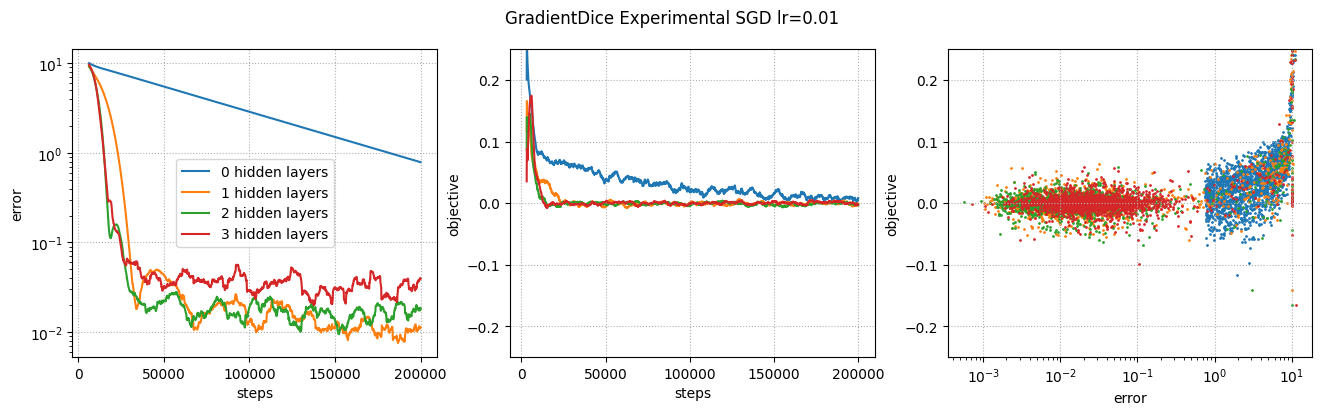

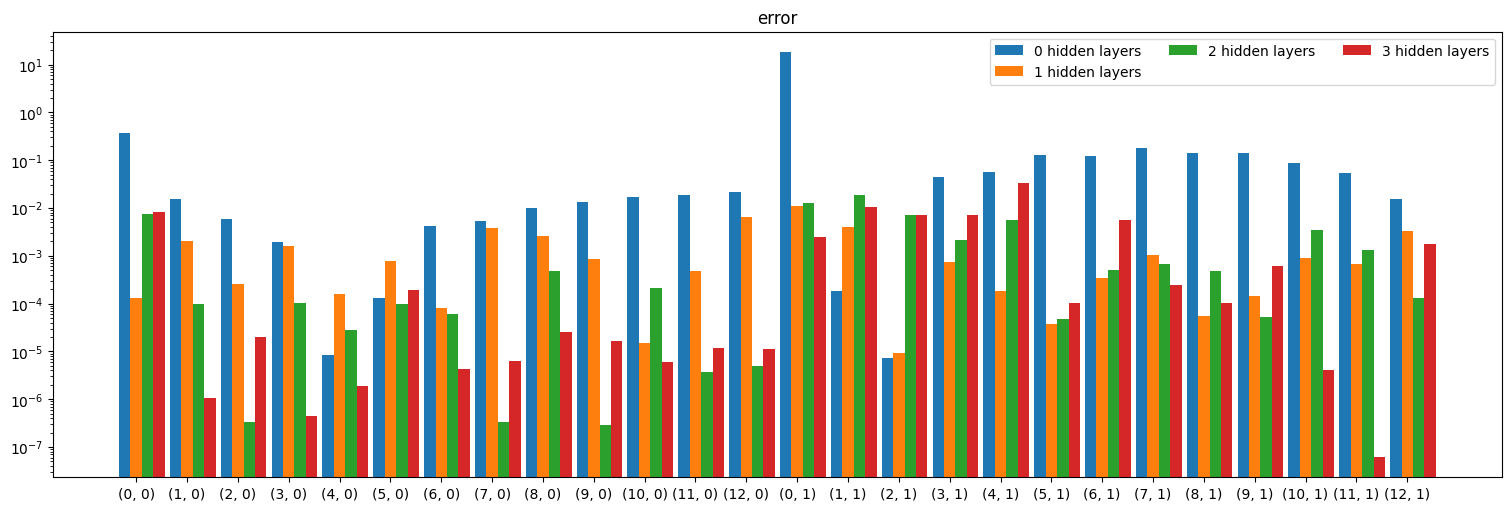

In [113]:
plot_agents(
    N=12, agents=agents_experimental_SGD[(0.01, False)], labels=[f"{i} hidden layers" for i, _ in enumerate(agents_experimental_SGD[(0.01, False)])],
    title="GradientDice Experimental SGD lr=0.01 bias=False", ma_mse=64, ma_obj=32, ma_se=None) # type: i bias=Falsegnore

## `bias=True`

In [18]:
agents_experimental_SGD[(0.05, True)] = []

try:
    for fc_layer_params in fc_layer_params_list:
        agent = BoyanChainAgent_Experimental(
            N=12, p=0.1,
            gamma=0.9, exponent=1.5, lam=1.0,
            num_steps=200_000, batch_size=64, learning_rate=0.05,
            max_approximate_solutions=16,
            feature_matrix_kind="one-hot", algorithm="GradientDice",
            optimizer="SGD", fc_layer_params=fc_layer_params, bias=True,
        )
        agent.eval_loop()
        agents_experimental_SGD[(0.05, True)].append(agent)

except: pass

100%|██████████| 200000/200000 [1:46:40<00:00, 31.25it/s, error=0.232, objective=0.0336]     


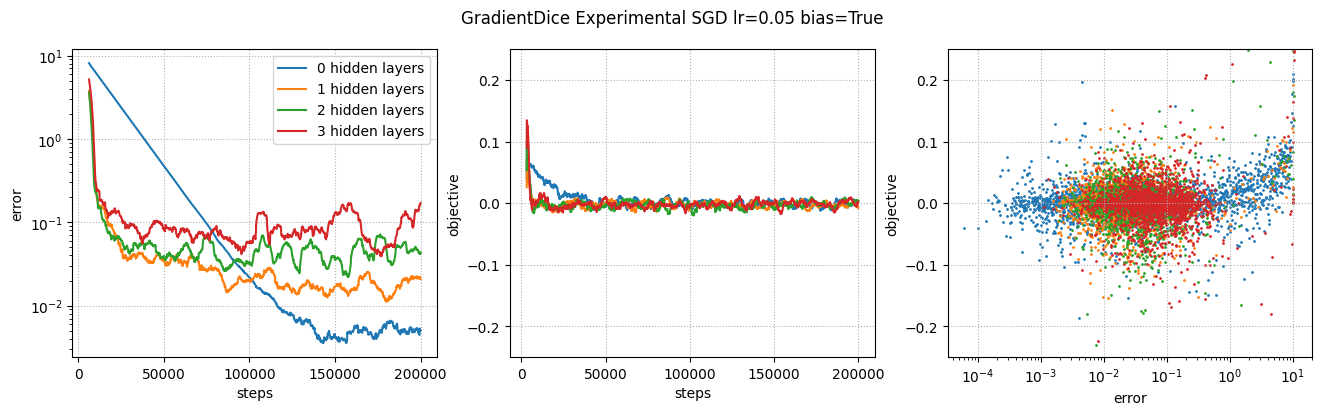

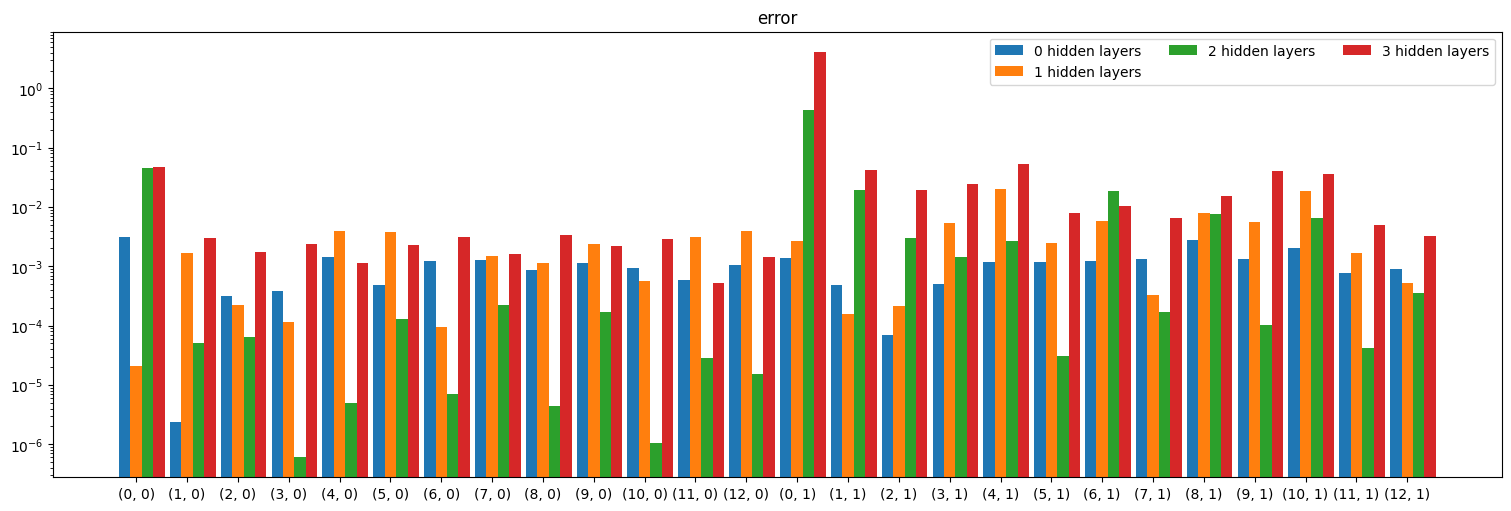

In [19]:
plot_agents(
    N=12, agents=agents_experimental_SGD[(0.05, True)], labels=[f"{i} hidden layers" for i, _ in enumerate(agents_experimental_SGD[(0.05, True)])],
    title="GradientDice Experimental SGD lr=0.05 bias=True", ma_mse=64, ma_obj=32, ma_se=None) # type: ignore

In [20]:
agents_experimental_SGD[(0.01, True)] = []

try:
    for fc_layer_params in fc_layer_params_list:
        agent = BoyanChainAgent_Experimental(
            N=12, p=0.1,
            gamma=0.9, exponent=1.5, lam=1.0,
            num_steps=200_000, batch_size=64, learning_rate=0.01,
            max_approximate_solutions=16,
            feature_matrix_kind="one-hot", algorithm="GradientDice",
            optimizer="SGD", fc_layer_params=fc_layer_params, bias=True,
        )
        agent.eval_loop()
        agents_experimental_SGD[(0.01, True)].append(agent)

except: pass

100%|██████████| 200000/200000 [1:47:01<00:00, 31.14it/s, error=0.0249, objective=0.00193]   


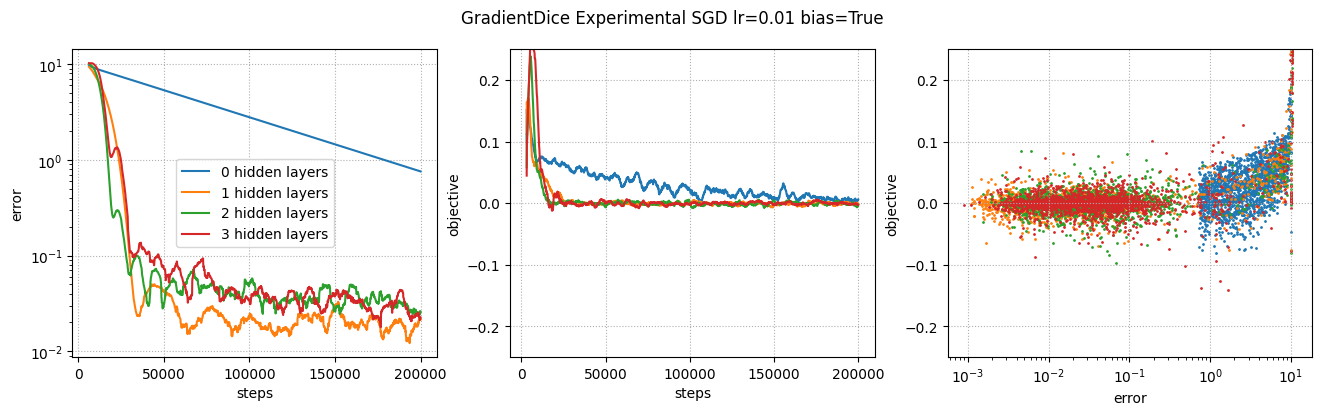

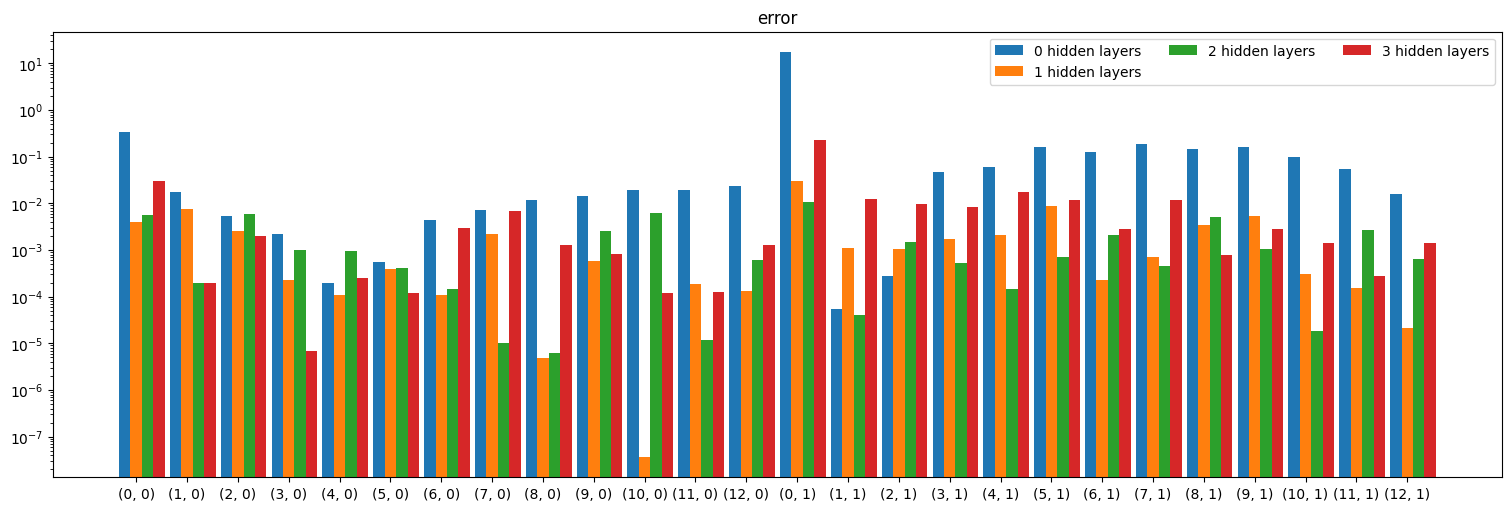

In [21]:
plot_agents(
    N=12, agents=agents_experimental_SGD[(0.01, True)], labels=[f"{i} hidden layers" for i, _ in enumerate(agents_experimental_SGD[(0.01, True)])],
    title="GradientDice Experimental SGD lr=0.01 bias=True", ma_mse=64, ma_obj=32, ma_se=None) # type: i bias=Falsegnore